In [1]:
import timecorr as tc
import supereeg as se
import numpy as np
import seaborn as sns
from timecorr.helpers import gaussian_weights, laplace_weights

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/opt/conda/lib/python3.6/site-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'TkAgg' by the following code:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt

## new wcorr function

In [2]:
def wcorr(a, b, weights, tol=1e-5):
    '''
    Compute moment-by-moment correlations between sets of observations

    :param a: a number-of-timepoints by number-of-features observations matrix
    :param b: a number-of-timepoints by number-of-features observations matrix
    :param weights: a number-of-timepoints by number-of-timepoints weights matrix
        specifying the per-timepoint weights to be considered (for each timepoint)
    :param tol: ignore all weights less than or equal (in absolute value) to tol
    :return: a a.shape[1] by b.shape[1] by weights.shape[0] array of per-timepoint
        correlation matrices.
    '''
    def weighted_mean_var_diffs(x, weights):
        weights[np.isnan(weights)] = 0
        if np.sum(weights) == 0:
            weights = np.ones(x.shape)

        weights_tiled = np.tile(weights[:, np.newaxis], [1, x.shape[1]])

        mx = np.sum(np.multiply(weights_tiled, x), axis=0)[:, np.newaxis].T


        diffs = x - np.tile(mx, [x.shape[0], 1])

        varx = np.sum(diffs ** 2, axis=0)[:, np.newaxis].T

        return mx, varx, diffs

    norm = np.sum(weights, axis=1)[:, np.newaxis]  # T by 1

    norma = np.tile(norm, [1, a.shape[1]])

    normb = np.tile(norm, [1, b.shape[1]])

    autocorrelation = np.isclose(a, b).all()

    corrs = np.zeros([a.shape[1], b.shape[1], weights.shape[1]])

    for t in np.arange(weights.shape[1]):
        ma, vara, diffs_a = weighted_mean_var_diffs(a, weights[:, t])

        if autocorrelation:
            mb = ma
            varb = vara
            diffs_b = diffs_a
        else:
            mb, varb, diffs_b= weighted_mean_var_diffs(b, weights[:, t])

        alpha = np.dot(diffs_a.T, diffs_b)

        beta = np.sqrt(np.dot(vara.T, varb))

        #corrs[:, :, t] = np.multiply(np.divide(alpha, beta), np.sqrt(norma[t] * normb[t]))
        corrs[:, :, t] = np.divide(alpha, beta)
    return corrs

## Get some data drawn from a toeplitx matrix 

In [3]:
locs = se.simulate_locations(n_elecs=20)
bo_s = se.simulate_bo(n_samples=1000, cov='toeplitz', locs=locs, noise=.1)

## Try some rolling correlations

In [4]:
rolling =bo_s.get_data().rolling(window=100,center=True).corr(other=bo_s.get_data()[0])
rolling_12 =bo_s.get_data().iloc[:,0].rolling(window=100).corr(other=bo_s.get_data().iloc[:,1])
rolling_22 =bo_s.get_data().iloc[:,1].rolling(window=100).corr(other=bo_s.get_data().iloc[:,1])


In [5]:
rolling[100:].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
100,1.0,0.959295,0.928078,0.859554,0.802391,0.751035,0.689350,0.653187,0.558932,0.471219,0.434575,0.391956,0.281139,0.206807,0.141085,0.103908,0.060739,-0.013127,-0.039270,-0.118370
101,1.0,0.960895,0.930400,0.862712,0.811685,0.760448,0.695519,0.659571,0.562872,0.477010,0.441855,0.389821,0.270850,0.194591,0.137798,0.093112,0.055574,-0.028212,-0.056490,-0.129189
102,1.0,0.962077,0.932114,0.868962,0.820527,0.776160,0.703246,0.661686,0.570407,0.478558,0.440428,0.385834,0.271546,0.193700,0.131486,0.086807,0.050656,-0.043668,-0.074745,-0.137181
103,1.0,0.963168,0.933083,0.873027,0.823208,0.782720,0.712687,0.671043,0.579405,0.488233,0.447065,0.387833,0.266113,0.195958,0.126455,0.084525,0.039718,-0.055116,-0.085638,-0.136966
104,1.0,0.963566,0.933169,0.873491,0.824365,0.783534,0.715628,0.672638,0.581511,0.490498,0.449774,0.390324,0.268953,0.201221,0.129805,0.086481,0.041335,-0.056215,-0.087051,-0.138975


In [6]:
rolling_22[100:].head()

100    1.0
101    1.0
102    1.0
103    1.0
104    1.0
Name: 1, dtype: float64

In [7]:
rolling_12[100:].head()

100    0.949162
101    0.950350
102    0.950711
103    0.951895
104    0.953143
dtype: float64

## Get the gaussian weights

In [8]:
gaussian_params = {'var': 100}

data = bo_s.get_data().values
T = data.shape[0]

weights = gaussian_weights(T, gaussian_params)

## Get the identity weights 

In [9]:
def wfun(T, gaussian_params):
    return np.eye(T)

eye_weights = wfun(T, {})

np.shape(eye_weights)

(1000, 1000)

## Get the Laplace weights

In [10]:
laplace_params = {'scale': 50}
laplace_weights = laplace_weights(T, laplace_params)

## Extract columns

In [11]:
col_1 = np.atleast_2d(data[:,0]).T

col_2 = np.atleast_2d(data[:,1]).T

## Confirm column 1 correlated with itself is the same as column one correlated with first column in array

In [12]:
corrs_multidim = wcorr(col_1, data, weights)

corrs_col = np.squeeze(wcorr(col_1, col_1, weights))


assert(np.allclose(corrs_col,corrs_multidim[0][0]))


In [13]:
corrs_col[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Confirm negative column 1 correlated with itself is negative ones

In [14]:
corrs_col_neg = np.squeeze(wcorr(-col_1, col_1, weights))

In [15]:
corrs_col_neg[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

## Confirm column 2 correlated with column 1 is the same as column 2 correlated with column 1 in array

In [16]:
corrs_col_12 = np.squeeze(wcorr(col_2, col_1, weights))

assert(np.allclose(corrs_col_12,corrs_multidim[0][1]))

In [17]:
corrs_col_12[:10]

array([0.9439508 , 0.94375889, 0.94358774, 0.94344098, 0.94332149,
       0.94323134, 0.94317178, 0.94314323, 0.94314522, 0.94317631])

## Confirm diagonal is ones when correlating 2d array with itself

In [18]:
corrs_col_arrays = np.squeeze(wcorr(data, data, weights))

In [19]:
corrs_col_arrays[2,2,500]

1.0000000000000004

## recover toeplitz matrix at each timepoint 

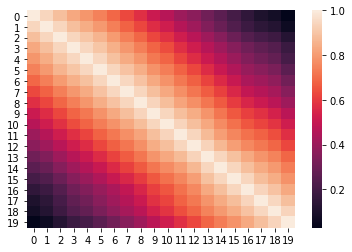

In [20]:
sns.heatmap(corrs_col_arrays[:,:,0])

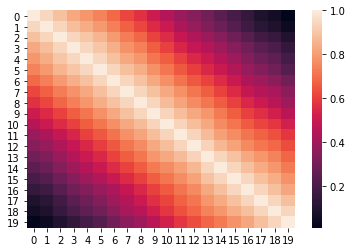

In [21]:
sns.heatmap(corrs_col_arrays[:,:,500])

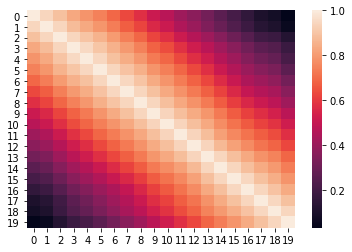

In [22]:
sns.heatmap(corrs_col_arrays[:,:,999])

## Again confirm toeplitz

In [23]:
from scipy.linalg import toeplitz
R = toeplitz(np.linspace(0, 1, 20)[::-1])

In [24]:
np.allclose(corrs_col_arrays[:,:,500], R, atol=.1)

True

## Try multiplying weights by constant

In [25]:
weights3 = weights*3

In [26]:
corrs_col = np.squeeze(wcorr(col_1, col_1, weights3))

In [27]:
corrs_col[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [28]:
corrs_multidim = wcorr(col_1, data, weights3)

In [29]:
corrs_multidim[:10]

array([[[1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [0.92971109, 0.92861395, 0.92757334, ..., 0.9517812 ,
         0.95128621, 0.95076366],
        [0.8731991 , 0.87200736, 0.87086764, ..., 0.90500181,
         0.90349221, 0.90179811],
        ...,
        [0.17802172, 0.18191022, 0.18425088, ..., 0.18559292,
         0.18783025, 0.18720223],
        [0.15047042, 0.15474484, 0.15748644, ..., 0.18895062,
         0.18975031, 0.18723204],
        [0.07744337, 0.08021834, 0.08196091, ..., 0.12076055,
         0.12356615, 0.1230461 ]]])

In [30]:
corrs_col_neg = np.squeeze(wcorr(-col_1, col_1, weights3))

In [31]:
corrs_col_neg[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

## All fine, but correlating 2d array with itself and extracting matrix at each timepoint, stuff gets weird

In [32]:
corrs_col_arrays_multiply= np.squeeze(wcorr(data, data, weights3))

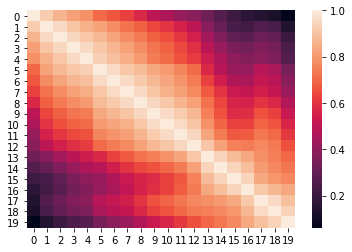

In [33]:
sns.heatmap(corrs_col_arrays_multiply[:,:,10])

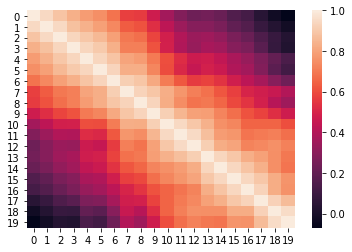

In [34]:
sns.heatmap(corrs_col_arrays_multiply[:,:,500])

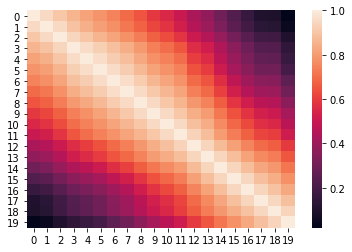

In [35]:
sns.heatmap(corrs_col_arrays_multiply[:,:,990])

## Try with identity matrix as weights

In [37]:
corrs_col_arrays_eye = np.squeeze(wcorr(data, data, eye_weights))

In [38]:
try_eye = np.squeeze(wcorr(col_1, data, eye_weights))

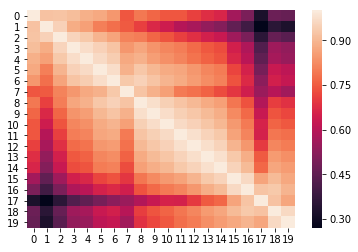

In [39]:
sns.heatmap(corrs_col_arrays_eye[:,:,990])

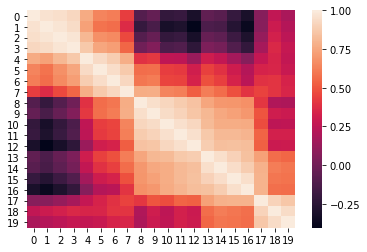

In [40]:
sns.heatmap(corrs_col_arrays_eye[:,:,500])

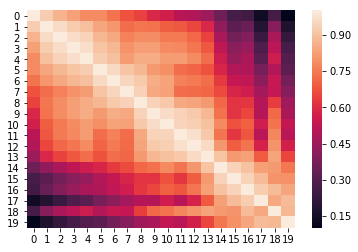

In [41]:
sns.heatmap(corrs_col_arrays_eye[:,:,5])

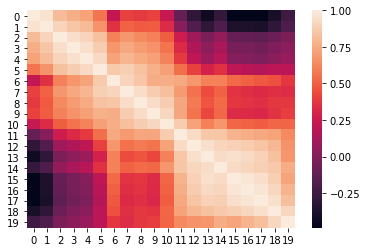

In [42]:
sns.heatmap(corrs_col_arrays_eye[:,:,100])

## Try with Laplace weights

In [44]:
corrs_col_arrays_laplace = np.squeeze(wcorr(data, data, laplace_weights))

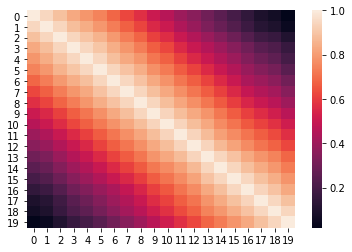

In [45]:
sns.heatmap(corrs_col_arrays_laplace[:,:,100])

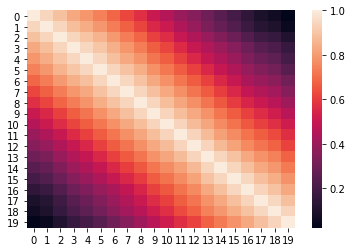

In [46]:
sns.heatmap(corrs_col_arrays_laplace[:,:,900])

In [47]:
np.shape(corrs_col_arrays_laplace)

(20, 20, 1000)

In [49]:
import scipy.spatial.distance as sd
def rmdiag(m):
    return m - np.diag(np.diag(m))

def mat2vec_worker(m):

    x = m.shape[0]
    v = np.zeros(((x*x - x)// 2) + x)
    v[0:x] = np.diag(m)

    # force m to be symmetric (sometimes rounding errors get introduced)
    m = np.triu(rmdiag(m))
    m += m.T

    v[x:] = sd.squareform(rmdiag(m))
    # before returning v, make every element of v an int?

    return v

def mat2vec(x):

    if x.ndim>2:
        K = x.shape[0]
        V = np.zeros([x.shape[2], int((K**2 - K)/2 + K)])
        for t in np.arange(x.shape[2]):
            V[t, :] = mat2vec_worker(np.squeeze(x[:, :, t]))
    else:

        V = mat2vec_worker(x)

    return V

In [50]:
mat2vec(corrs_col_arrays_laplace[:,:,500])

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.94648183, 0.88978448, 0.831809  , 0.78697135, 0.74339323,
       0.68680035, 0.62455057, 0.57364938, 0.50768175, 0.46255834,
       0.40025241, 0.35790151, 0.3023546 , 0.25183211, 0.2029326 ,
       0.14786813, 0.09615665, 0.06916517, 0.02224585, 0.94518845,
       0.88429943, 0.83973564, 0.79275571, 0.73449795, 0.67177885,
       0.620257  , 0.55453384, 0.50850326, 0.44335508, 0.39370316,
       0.33448921, 0.28359096, 0.23293203, 0.1754301 , 0.12347089,
       0.1007697 , 0.0506483 , 0.94400541, 0.9000034 , 0.85744816,
       0.79545027, 0.73501582, 0.68113027, 0.61293525, 0.56753991,
       0.50426622, 0.45138091, 0.39712305, 0.3468211 , 0.29518781,
       0.23692295, 0.18665849, 0.16616575, 0.11141146, 0.94947

In [51]:
corrs_col_arrays_gaussian= np.squeeze(wcorr(data, data, weights))

In [53]:
c1 = mat2vec(corrs_col_arrays_eye)
c2 = mat2vec(corrs_col_arrays_laplace)
c3 = mat2vec(corrs_col_arrays_gaussian)

In [54]:
import hypertools as hyp

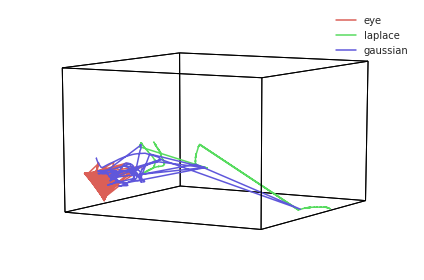

In [55]:
hyp.plot([c1, c2, c3], reduce='UMAP', legend=['eye', 'laplace', 'gaussian'])

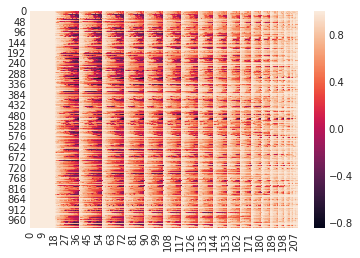

In [56]:
sns.heatmap(c1)

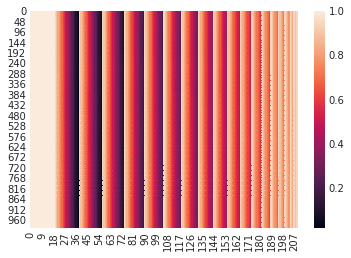

In [57]:
sns.heatmap(c2)

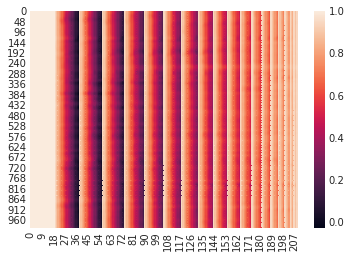

In [58]:
sns.heatmap(c3)

In [ ]:
## try negative eye matrix